# Convolutional Neural Network Model - Hiperparameters Tuning

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Dropout
from keras.regularizers import L2
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold
import keras_tuner

from helper_functions import train_and_evaluate_model, calculate_returns_for_model, calculate_metrics, daily_to_annual_returns

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

In [4]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

Preparing outputs common for all models

In [5]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [6]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_tight_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])

    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

Cannot get optimal portfolio for 2022-05-06 00:00:00
Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-03-03 00:00:00
Cannot get optimal portfolio for 2023-05-04 00:00:00


(288, 27)

In [7]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
y_train = y[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
y_val = y[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
y_test = y[test_split:]

In [8]:
os.chdir(os.path.expanduser('../data'))

In [9]:
df_prices_val = df_countries[dates_for_validation[0]:]
df_returns_val = np.log(df_prices_val).diff().fillna(0)

## Cross validation to calculate optimal number of months

In [20]:
max_sharpe = 0
best_month_no = 0

for no_months in range(3, 10):
    print(f'CNN Model for {no_months} months')
    x = []
    for date in days_to_recalculate:
        indicators = data_provider.calculate_principal_component_from_indicators(
            date, periods=no_months, indicators=all_indicators)
        x.append(indicators.values)

    x_pca = np.array(x)
    x_train = x_pca[:val_split]
    x_val = x_pca[val_split:test_split]
    x_test = x_pca[test_split:]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(x_train, y_train)

    sum_sharpe = 0
    for _, (train_index, val_index) in enumerate(skf.split(x_train, np.zeros(y_train.shape[0]))):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        model = Sequential((
            Conv1D(32, 3, input_shape=x_train.shape[1:]),
            Flatten(),
            Dropout(0.3),
            Dense(16, activation='relu', kernel_regularizer=L2(0.3)),
            Dense(y_train.shape[1], activation='softmax')
        ))
        model.compile(optimizer=Adam(learning_rate=1e-3),
                      loss='mean_squared_error')
        _ = model.fit(x_train_fold, y_train_fold,
                      validation_data=(x_val_fold, y_val_fold),
                      epochs=200, verbose=False)

        total_ret_val, _ = calculate_returns_for_model(
            model, x_val, dates_for_validation,
            df_returns_val, df_countries.columns)

        annual_returns = daily_to_annual_returns(total_ret_val)
        annual_volatility = total_ret_val.std()*np.sqrt(252)
        annual_sharpe_val = annual_returns/annual_volatility
        sum_sharpe += annual_sharpe_val
        print('Sharpe fold', annual_sharpe_val)

    mean_sharpe_val = sum_sharpe/5
    print('Mean Sharpe', mean_sharpe_val)
    if mean_sharpe_val > max_sharpe:
        max_sharpe = mean_sharpe_val
        best_month_no = no_months

print('Best number of months', best_month_no, 'with mean Sharpe ratio', max_sharpe)

CNN Model for 3 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sharpe fold 0.3887538127969205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.39586553024950855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.3910559998735833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.40010719195145633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sharpe fold 0.37897474806355735
Mean Sharpe 0.3909514565870052
CNN Model for 4 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sharpe fold 0.39051319129453155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.38789375565000633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.3943206050383288
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.38735793356392995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.38757488308134125
Mean Sharpe 0.38953207372562754
CNN Model for 5 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.40228276339209884
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.39321571093134394
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.3913100541107186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sharpe fold 0.37447562278370966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sharpe fold 0.36658217848990365
Mean Sharpe 0.38557326594155494
CNN Model for 6 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sharpe fold 0.39054197677559555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.42173792749442895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.3892407659473138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.39284256536008755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sharpe fold 0.41958607400450143
Mean Sharpe 0.4027898619163855
CNN Model for 7 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.3958623292812362
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sharpe fold 0.3976635411230897
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sharpe fold 0.4045754099162244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sharpe fold 0.3786197620418773
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sharpe fold 0.3894133816490854
Mean Sharpe 0.39322688480230267
CNN Model for 8 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.40412908714282686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.4051925359511208
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.38386390934244236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.391377461091266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sharpe fold 0.3968856389157743
Mean Sharpe 0.39628972648868604
CNN Model for 9 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.415979492880098
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sharpe fold 0.39444186651846247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.3803921653377538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Sharpe fold 0.3995655505033702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.4232057453860967
Mean Sharpe 0.4027169641251563
Best number of months 6 with mean Sharpe ratio 0.4027898619163855


In [10]:
best_month_no = 6

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=best_month_no, indicators=all_indicators)
    x.append(indicators.values)

x_pca = np.array(x)
x_train = x_pca[:val_split]
x_val = x_pca[val_split:test_split]
x_test = x_pca[test_split:]

## Hiperparameters Tuning

In [79]:
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(hp.Choice('conv1_units', [32, 64, 128, 256]), 3,
                     input_shape=x_train.shape[1:]))

    if hp.Boolean("second_layer"):
        model.add(Conv1D(hp.Choice('conv2_units', [32, 64, 128, 256]), 3))

    model.add(Flatten())
    model.add(Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3])))

    model.add(Dense(hp.Choice('dense_units', [32, 64, 128]), activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='mse')
    return model

In [80]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=300,
    directory='tuning',
    project_name='model_cnn')

Reloading Tuner from tuning\model_cnn\tuner0.json


In [81]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
conv1_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
second_layer (Boolean)
{'default': False, 'conditions': []}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3], 'ordered': True}
dense_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
conv2_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}


In [82]:
tuner.search(x_train, y_train, epochs=150, validation_data=(x_val, y_val))

In [83]:
tuner.results_summary()

Results summary
Results in tuning\model_cnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 209 summary
Hyperparameters:
conv1_units: 256
second_layer: False
dropout: 0.1
dense_units: 32
conv2_units: 128
Score: 0.0004806154465768486

Trial 055 summary
Hyperparameters:
conv1_units: 128
second_layer: True
dropout: 0.2
dense_units: 128
conv2_units: 256
Score: 0.0004806294455192983

Trial 047 summary
Hyperparameters:
conv1_units: 256
second_layer: False
dropout: 0.3
dense_units: 64
conv2_units: 32
Score: 0.00048525843885727227

Trial 027 summary
Hyperparameters:
conv1_units: 256
second_layer: False
dropout: 0.3
dense_units: 64
conv2_units: 64
Score: 0.0004856258456129581

Trial 096 summary
Hyperparameters:
conv1_units: 256
second_layer: True
dropout: 0.1
dense_units: 64
conv2_units: 32
Score: 0.0004888686817139387

Trial 275 summary
Hyperparameters:
conv1_units: 256
second_layer: False
dropout: 0.3
dense_units: 128
conv2_units: 32
Score: 0.0004902514046989381

Tri

## Best Model training

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 4, 256)         │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 2, 128)         │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,627 (537.61 KB)

 Trainable params: 137,627 (537.61 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0061 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 8.9167e-04 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 7.1682e-04 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 6.9063e-04 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 5.9642e-04 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2981e-04 - val_loss: 6.2122e-04 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8136e-04 - val_loss: 6.4911e-04 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0310e-04 - val_loss: 6.3951e-04 - learning_rate: 0.

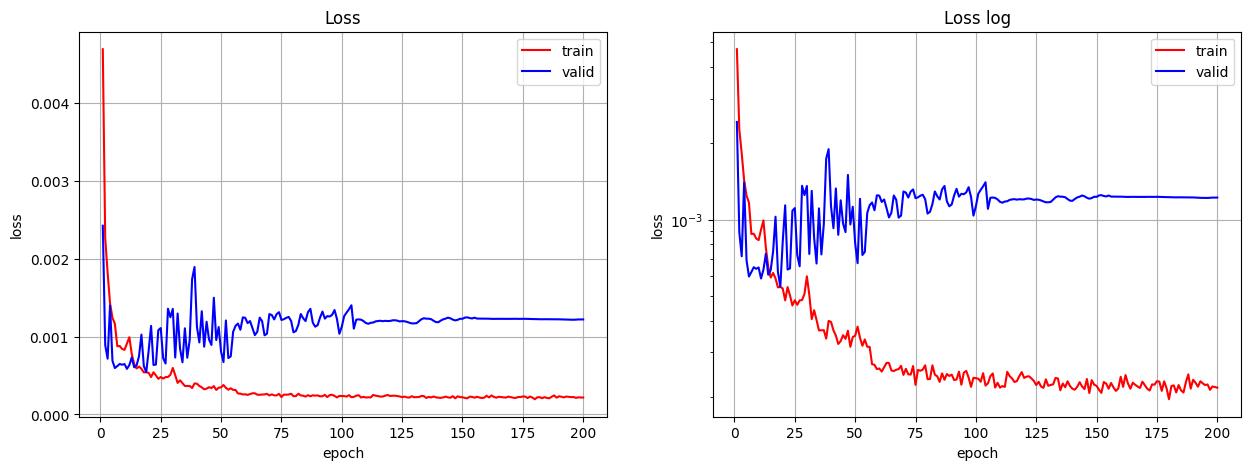

In [69]:
#best_model = tuner.get_best_models()[0]

best_model = Sequential((
    Conv1D(256, 3, input_shape=x_train.shape[1:]),
    Conv1D(128, 3),
    Flatten(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(best_model, x_train, y_train,
                         x_val, y_val, x_test, y_test)

## Backtesting

In [70]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [71]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [72]:
total_returns_model_dnn, cum_total_returns_model_dnn = calculate_returns_for_model(
    best_model, x_test, dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


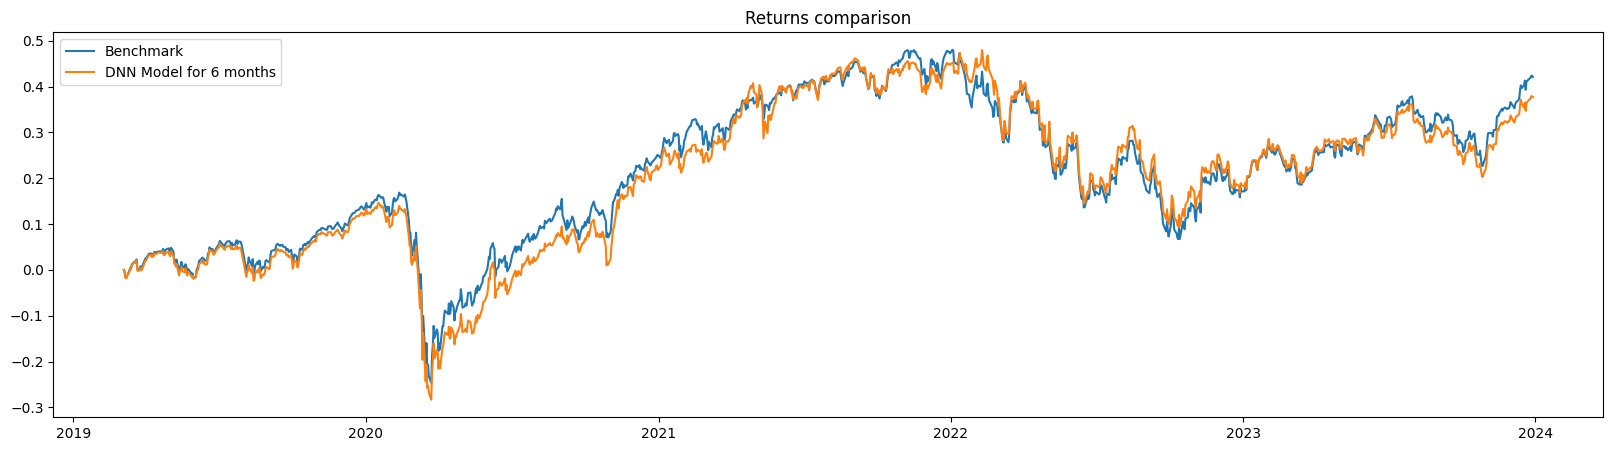

In [73]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_returns_model_dnn,
         label=f'DNN Model for {best_month_no} months')

plt.legend()
plt.title('Returns comparison')
plt.show()

In [74]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_model_dnn, df_results,
                  f'DNN Model for {best_month_no} months', benchmark_returns)
df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
DNN Model for 6 months,0.068662,0.209132,0.328317,0.379067,-0.374917,474.0,0.183139,-0.117079
